# Tipos de fuentes de datos: estructuradas, semiestructuradas y no estructuradas

Este notebook explica los tres grandes tipos de fuentes de datos, sus diferencias, ventajas y desventajas, y cómo trabajar con ellas en Python con ejemplos prácticos.


## Resumen comparativo

| Tipo | Estructura | Ejemplos | Formatos comunes | Dónde suelen vivir | Ventajas | Desventajas |
|---|---|---|---|---|---|---|
| **Estructurados** | Esquema rígido (tablas: filas/columnas) | hojas de cálculo, registros transaccionales | CSV, TSV, Parquet, bases SQL | RDBMS (PostgreSQL, MySQL), data warehouses | Consultas potentes (SQL), integridad, calidad | Rigidez ante cambios de esquema |
| **Semiestructurados** | Esquema flexible basado en etiquetas/pares clave-valor | Logs, respuestas de API | **JSON**, XML, YAML, etc. | NoSQL (MongoDB), data lakes | Evolución sencilla, anidamiento | Consultas menos directas, validación coherente |
| **No estructurados** | Sin esquema predefinido | Texto libre, imágenes, audio, video, PDFs, emails | TXT, PDF, JPG/PNG, MP3/MP4 | Sistemas de archivos, repositorios de contenido, data lakes | Riqueza semántica, mayoría del volumen real | Requiere NLP y otros, extracción costosa |

> Nota: muchos contenedores (por ejemplo PDF) **pueden incluir metadatos estructurados**, pero su **cuerpo** sigue siendo no estructurado.


---
## Datos **estructurados**

**Definición.** Datos con un **esquema fijo** y entidades/atributos bien definidos. Se organizan en tablas (filas y columnas).  
**Cuándo usarlos.** Transacciones, reportes operativos, BI, uniones y agregaciones frecuentes, **calidad e integridad altas**.  
**Pros.** SQL, validaciones, rendimiento de consulta, control de integridad.  
**Contras.** Cambiar el esquema puede ser costoso; menor flexibilidad para datos novedosos.


### Ejemplo: tablas `clientes` y `ventas`

- Creamos dos tablas sintéticas.
- Hacemos una **JOIN** y agregamos métricas.
- Graficamos un **resumen** con matplotlib.


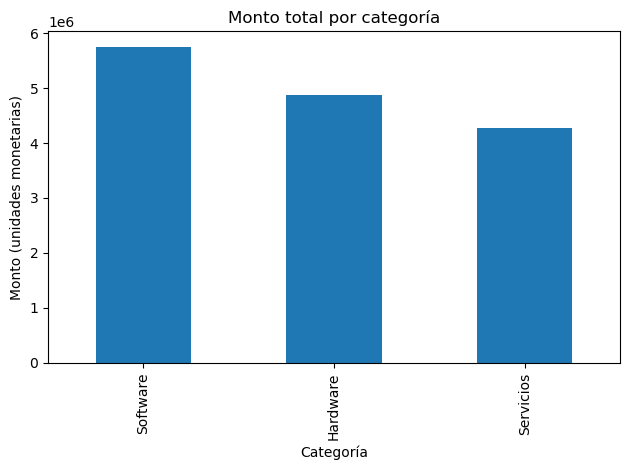

,venta_id,fecha,cliente_id,categoria,monto,nombre,ciudad,segmento
0,1,2025-01-10,101,Servicios,1140191.29,Ana,Bogotá,Retail
1,2,2025-01-12,103,Hardware,844758.19,Carla,Cali,Retail
2,3,2025-01-13,102,Software,878626.25,Bruno,Medellín,Enterprise
3,4,2025-01-15,106,Software,846673.72,Fabio,Medellín,SMB
4,5,2025-01-18,102,Software,1168888.14,Bruno,Medellín,Enterprise
5,6,2025-02-01,101,Software,857058.77,Ana,Bogotá,Retail
6,7,2025-02-03,106,Servicios,1116348.94,Fabio,Medellín,SMB
7,8,2025-02-07,104,Hardware,1076609.77,Diego,Barranquilla,SMB
8,9,2025-02-08,102,Servicios,994955.83,Bruno,Medellín,Enterprise
9,10,2025-02-15,106,Hardware,962349.73,Fabio,Medellín,SMB


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Datos estructurados sintéticos ---
clientes = pd.DataFrame({
    "cliente_id": [101, 102, 103, 104, 105, 106],
    "nombre": ["Ana", "Bruno", "Carla", "Diego", "Elena", "Fabio"],
    "ciudad": ["Bogotá", "Medellín", "Cali", "Barranquilla", "Bogotá", "Medellín"],
    "segmento": ["Retail", "Enterprise", "Retail", "SMB", "Enterprise", "SMB"]
})

ventas = pd.DataFrame({
    "venta_id": range(1, 16),
    "fecha": pd.to_datetime([
        "2025-01-10","2025-01-12","2025-01-13","2025-01-15","2025-01-18",
        "2025-02-01","2025-02-03","2025-02-07","2025-02-08","2025-02-15",
        "2025-03-01","2025-03-05","2025-03-07","2025-03-15","2025-03-20"
    ]),
    "cliente_id": np.random.choice(clientes["cliente_id"], size=15, replace=True),
    "categoria": np.random.choice(["Hardware","Software","Servicios"], size=15, replace=True),
    "monto": np.round(np.random.uniform(800000, 1200000, size=15), 2)
})

# --- Unión y análisis ---
df = ventas.merge(clientes, on="cliente_id", how="left")

resumen_cat = df.groupby("categoria")["monto"].sum().sort_values(ascending=False)

# --- Visualización --
plt.figure()
resumen_cat.plot(kind="bar")
plt.title("Monto total por categoría")
plt.xlabel("Categoría")
plt.ylabel("Monto (unidades monetarias)")
plt.tight_layout()
plt.show()

df.head(10)  # vista rápida


### Validación de esquema

Ejemplo de comprobaciones comunes: tipos, nulos y dominios de valores.


In [ ]:
# Tipos esperados
expected = {
    "venta_id": "int64",
    "fecha": "datetime64[ns]",
    "cliente_id": "int64",
    "categoria": "object",
    "monto": "float64"
}

actual = {col: str(df[col].dtype) for col in expected}
mismatches = {c: (actual[c], expected[c]) for c in expected if actual[c] != expected[c]}
print("Diferencias de tipo:", mismatches if mismatches else "Ninguna")

# Reglas simples
assert df["monto"].ge(0).all(), "Hay montos negativos"
assert df["categoria"].isin(["Hardware","Software","Servicios"]).all(), "Categoría fuera de dominio"

# Nulos
nulls = df.isna().sum()
print("Nulos por columna:\n", nulls)


---
## 2) Datos **semiestructurados**

**Definición.** No siguen un esquema tabular rígido, pero contienen **estructura explícita** (etiquetas/pares clave-valor, anidamientos).  
**Ejemplos.** JSON/XML de APIs, logs de eventos, mensajería, configuraciones.  
**Pros.** Flexible, evoluciona sin migraciones complejas, admite anidamientos y opcionales.  
**Contras.** Consultas menos directas; normalización/validación coherente es clave.


### Ejemplo A: normalizar **JSON** de eventos

- Generamos una lista de eventos con anidamientos y campos opcionales.
- Usamos `pandas.json_normalize` para aplanar.
- Contamos eventos por severidad y graficamos.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

logs = [
    {
        "timestamp": "2025-03-01T10:00:00Z",
        "service": "auth",
        "severity": "INFO",
        "user": {"id": 101, "role": "admin"},
        "action": "login",
        "payload": {"ip": "10.0.0.1", "agent": {"browser": "Chrome", "version": "123"}},
    },
    {
        "timestamp": "2025-03-01T10:05:12Z",
        "service": "billing",
        "severity": "WARN",
        "action": "charge_failed",
        "payload": {"ip": "10.0.0.2", "error_code": "CARD_DECLINED"},
    },
    {
        "timestamp": "2025-03-01T10:06:48Z",
        "service": "auth",
        "severity": "ERROR",
        "user": {"id": 102, "role": "viewer"},
        "action": "login",
        "payload": {"ip": "10.0.0.3", "agent": {"browser": "Firefox", "version": "124"}},
    },
    {
        "timestamp": "2025-03-01T10:07:02Z",
        "service": "orders",
        "severity": "INFO",
        "user": {"id": 103, "role": "editor"},
        "action": "create_order",
        "payload": {"ip": "10.0.0.4", "items": [{"sku": "A1","qty": 2},{"sku": "B9","qty": 1}]},
    },
]

df_logs = pd.json_normalize(logs, sep=".")
display_cols = [c for c in df_logs.columns if not c.startswith("payload.items")]
df_logs[display_cols].head(10)


,timestamp,service,severity,action,user.id,user.role,payload.ip,payload.agent.browser,payload.agent.version,payload.error_code
0,2025-03-01T10:00:00Z,auth,INFO,login,101.0,admin,10.0.0.1,Chrome,123,NaN
1,2025-03-01T10:05:12Z,billing,WARN,charge_failed,NaN,NaN,10.0.0.2,NaN,NaN,CARD_DECLINED
2,2025-03-01T10:06:48Z,auth,ERROR,login,102.0,viewer,10.0.0.3,Firefox,124,NaN
3,2025-03-01T10:07:02Z,orders,INFO,create_order,103.0,editor,10.0.0.4,NaN,NaN,NaN


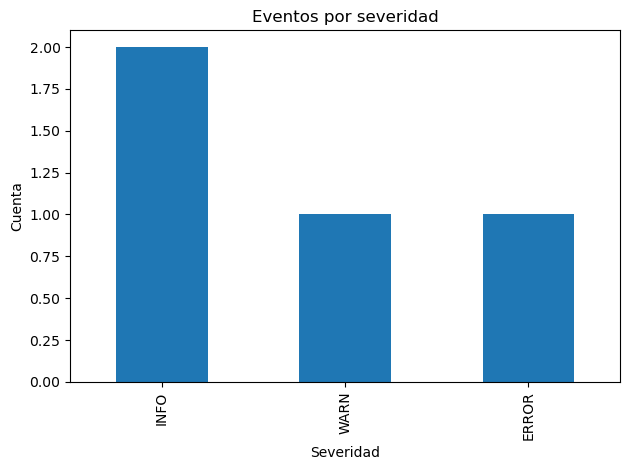

In [4]:
# Conteo por severidad y gráfico simple
counts = df_logs["severity"].value_counts()

import matplotlib.pyplot as plt
plt.figure()
counts.plot(kind="bar")
plt.title("Eventos por severidad")
plt.xlabel("Severidad")
plt.ylabel("Cuenta")
plt.tight_layout()
plt.show()


### Ejemplo B: extraer campos desde **XML**

- Parseamos un catálogo de libros (XML).
- Aplanamos etiquetas y atributos para un DataFrame.


In [7]:
import xml.etree.ElementTree as ET
import pandas as pd

xml_str = '''
<catalog>
  <book id="b1">
    <title>Ingeniería de Datos</title>
    <author>A. Rivera</author>
    <year>2021</year>
    <price currency="USD">39.90</price>
    <tags><tag>ETL</tag><tag>Modelado</tag></tags>
  </book>
  <book id="b2">
    <title>APIs con Python</title>
    <author>L. Gómez</author>
    <year>2023</year>
    <price currency="EUR">29.00</price>
    <tags><tag>API</tag><tag>Web</tag></tags>
  </book>
  <book id="b3">
    <title>Bases NoSQL</title>
    <author>M. Torres</author>
    <year>2020</year>
    <price currency="USD">35.50</price>
    <tags><tag>NoSQL</tag><tag>Escalabilidad</tag></tags>
  </book>
</catalog>
'''

root = ET.fromstring(xml_str)
rows = []
for book in root.findall("book"):
    book_id = book.attrib.get("id")
    title = book.findtext("title")
    author = book.findtext("author")
    year = int(book.findtext("year"))
    price_el = book.find("price")
    price = float(price_el.text)
    currency = price_el.attrib.get("currency")
    tags = [t.text for t in book.findall("tags/tag")]
    rows.append({
        "id": book_id, "title": title, "author": author, "year": year,
        "price": price, "currency": currency, "tags": ", ".join(tags)
    })

df_books = pd.DataFrame(rows)
df_books


,id,title,author,year,price,currency,tags
0,b1,Ingeniería de Datos,A. Rivera,2021,39.9,USD,"ETL, Modelado"
1,b2,APIs con Python,L. Gómez,2023,29.0,EUR,"API, Web"
2,b3,Bases NoSQL,M. Torres,2020,35.5,USD,"NoSQL, Escalabilidad"


---
## Datos **no estructurados**

**Definición.** No tienen un esquema predefinido. El contenido principal es libre (texto, binarios, multimedia).  
**Ejemplos.** Documentos de texto/PDF, imágenes (JPG/PNG), audio, video, correos, transcripciones.  
**Pros.** Máxima riqueza semántica; captura la complejidad del mundo real.  
**Contras.** Requiere **NLP** (texto) o **Computer Vision** (imágenes/video); extracción y búsqueda son más costosas.


### Ejemplo A: procesamiento básico de **texto**

- Tokenización simple, eliminación de stopwords y conteo de palabras.
- Extracción de patrones con expresiones regulares.


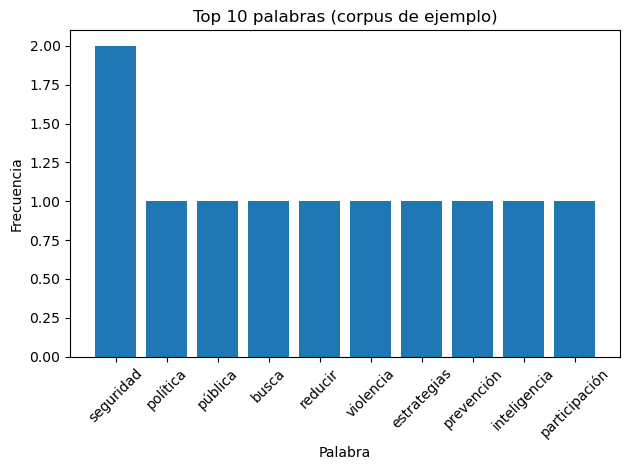

,palabra,frecuencia
0,seguridad,2
1,política,1
2,pública,1
3,busca,1
4,reducir,1
5,violencia,1
6,estrategias,1
7,prevención,1
8,inteligencia,1
9,participación,1


In [8]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

docs = {
    "politica_seguridad.txt": """
La política pública de seguridad busca reducir la violencia mediante estrategias 
de prevención, inteligencia y participación comunitaria. Contacto: seguridad@alcaldia.gov.
Reunión programada para 12/03/2025.
""",
    "informe_tecnico.txt": """
Este informe técnico evalúa variables ambientales (temperatura y humedad) y su relación
con el funcionamiento de equipos. Responsable: carla.romero@universidad.edu.
Próxima calibración: 2025-04-15.
"""
}

stopwords = set("""de la el y en que los las un una para es se con por del al lo como más o
mediante su sus este esta eso esa entre sobre a e u
""".split())

tokens = []
for name, text in docs.items():
    words = re.findall(r"\b\w+\b", text.lower(), flags=re.UNICODE)
    words = [w for w in words if w not in stopwords and not w.isdigit()]
    tokens.extend(words)

freq = Counter(tokens)
top = freq.most_common(10)
df_top = pd.DataFrame(top, columns=["palabra","frecuencia"])

# Visualización simple
plt.figure()
plt.bar(df_top["palabra"], df_top["frecuencia"])
plt.title("Top 10 palabras (corpus de ejemplo)")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_top


In [9]:
# Extracción de patrones (regex): correos y fechas
text_all = "\n".join(docs.values())
emails = re.findall(r"[\w\.-]+@[\w\.-]+", text_all)
# fechas tipo DD/MM/AAAA o AAAA-MM-DD
dates = re.findall(r"(?:\b\d{2}/\d{2}/\d{4}\b|\b\d{4}-\d{2}-\d{2}\b)", text_all)

print("Correos detectados:", emails)
print("Fechas detectadas:", dates)


Correos detectados: ['seguridad@alcaldia.gov.', 'carla.romero@universidad.edu.']
Fechas detectadas: ['12/03/2025', '2025-04-15']


---
## 4) Checklist de clasificación

- ¿Tiene tablas claras de **filas/columnas**? → **Estructurado**.
- ¿Tiene **etiquetas/pares clave-valor**, puede **anidarse** y algunos campos faltan? → **Semiestructurado**.
- ¿El cuerpo es **texto o binario libre** (PDF, imagen, audio, video)? → **No estructurado**.

## 5) Elegir la ruta adecuada (ingestión, almacenamiento, gobierno)

**Preguntas guía:**
1. ¿El **esquema** es estable y tabular? Base SQL / warehouse (**estructurados**).
2. ¿Necesitas **anidamiento** y evolución rápida? JSON/XML en NoSQL o datalake (**semiestructurados**).
3. ¿El contenido es texto/multimedia? Almacenamiento de objetos + indexación/embeddings (**no estructurados**).

**Diseños comunes:**
- **Data Warehouse**: hechos y dimensiones, BI y reportes, datos limpios y gobernados.
- **Data Lake**: almacenamiento económico de datos crudos (bronce) + enriquecidos (plata) + curados (oro).
- **Lakehouse**: transaccionalidad ligera sobre el lake para analítica y gobernanza unificada.
- **Catálogo/Metadatos**: Muestra orígenes, esquemas, calidad, políticas, etc.
